In [1]:
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from random import shuffle
from datetime import timedelta
from PIL import Image
from pylab import rcParams
import os
import cv2
import math
import time
import random
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc as scm
import matplotlib.image as mpimg
import pylab as pl
rcParams['figure.figsize'] = 8, 8

CLASSIFIER_NAME = 'PhotoClassifier'
BASE_DIR = 'C:/pythonprojects/cameroocnn/'
TRAIN_DIR = 'train_images/'
TEST_DIR = 'test_images/'
ORI_TRAIN_IMG_DIR = 'train_images/ori/'
ORI_TEST_IMG_DIR = 'test_images/ori/'
RSZ_TRAIN_IMG_DIR = 'train_images/rsz/'
RSZ_TEST_IMG_DIR = 'test_images/rsz/'

In [2]:
# Image width and height
IMG_SIZE = 128

# Backpropagation times
NUM_ITERATIONS = 350

# Learning Rate
# LEARNING_RATE = 1e-4
LEARNING_RATE = 1e-3

# 1st Convolutional Layer
CL1_FILTER_SIZE = 5
CL1_NUM_FILTERS = 32

# 2nd Convolutional Layer
CL2_FILTER_SIZE = 5
CL2_NUM_FILTERS = 32

# 3rd Convolutional Layer
CL3_FILTER_SIZE = 5
CL3_NUM_FILTERS = 64

# Fully-connected layer size
FC_SIZE = 128

# RGB channels
RGB_CHANNELS = 3

# Pixal vector size of image
VECTOR_SIZE = IMG_SIZE * IMG_SIZE * RGB_CHANNELS

IMG_SHAPE = IMG_SIZE * IMG_SIZE

CATEGORIES = ['people', 'building', 'car', 'plant', 'scenery', 'food']
NUM_CATEGORIES = len(CATEGORIES)

# Batch size
BATCH_SIZE = 3

In [3]:
def label_img(img):
    
    label = img.split('.')[-3]
    
    if label == 'building':
        return [1, 0, 0, 0, 0, 0]
    
    elif label == 'car':
        return [0, 1, 0, 0, 0, 0]
    
    elif label == 'food':
        return [0, 0, 1, 0, 0, 0]
    
    elif label == 'people':
        return [0, 0, 0, 1, 0, 0]
    
    elif label == 'plant':
        return [0, 0, 0, 0, 1, 0]
    
    elif label == 'scenery':
        return [0, 0, 0, 0, 0, 1]

In [4]:
def plot_image(image):
    plt.imshow(image.reshape(128, 128, 3),
               interpolation='nearest',
               cmap='binary')

    plt.show()

In [5]:
def resize_images(image_type):
    
    if image_type == "train":
        ORI_IMG_DIR = ORI_TRAIN_IMG_DIR
        RSZ_IMG_DIR = RSZ_TRAIN_IMG_DIR
    else:
        ORI_IMG_DIR = ORI_TEST_IMG_DIR
        RSZ_IMG_DIR = RSZ_TEST_IMG_DIR
    
    for img_category in os.listdir(ORI_IMG_DIR):

        ori_img_categories_dir = ORI_IMG_DIR + img_category + '/'
        rsz_img_categories_dir = RSZ_IMG_DIR
        
#         os.makedirs(rsz_img_categories_dir)

#         print(rsz_img_categories_dir)
        full_rsz_dir = BASE_DIR + rsz_img_categories_dir
#         print(full_rsz_dir)

        img_num = 1

        for img_name in os.listdir(ori_img_categories_dir):
            img = scm.imread(ori_img_categories_dir + img_name)
#             pl.subplot(121)
#             pl.imshow(img)

            img = scm.imresize(img, (IMG_SIZE, IMG_SIZE))
            print(img_name)
            print(img.shape)
#             pl.subplot(122)
#             pl.imshow(img)
#             pl.show()

            new_img_path_string = full_rsz_dir + img_category + '.' + str(img_num) + '.jpg'
    
            scm.imsave(new_img_path_string, img)

#             cv2.imwrite(new_img_path_string, img)
#             cv2.imwrite(new_img_path_string, cv2.cvtColor(scm.imread(new_img_path_string), cv2.COLOR_BGR2RGB))
#             plot_image(scm.imread(new_img_path_string))
            print(new_img_path_string)

            img_num = img_num + 1
        

In [6]:
if not os.path.isdir(RSZ_TRAIN_IMG_DIR):
    os.makedirs(RSZ_TRAIN_IMG_DIR)
    resize_images("train")
if not os.path.isdir(RSZ_TEST_IMG_DIR):
    os.makedirs(RSZ_TEST_IMG_DIR)
    resize_images("test")

In [7]:
def get_all_train_data():
    
    training_data = []
    
    for img in os.listdir(RSZ_TRAIN_IMG_DIR):
        training_data.append(img)
    
    return training_data

def get_all_test_data():
    
    testing_data = []
    
    for img in os.listdir(RSZ_TEST_IMG_DIR):
        testing_data.append(img)
    
    return testing_data
        
training_data = get_all_train_data()
testing_data = get_all_test_data()

In [8]:
def get_next_batch(batch_size):
    
    random.shuffle(training_data)
    
    x_value = []
    y_value = []
    
    counter = 0
    
    for img in training_data:
        
        x_value.append(scm.imread(RSZ_TRAIN_IMG_DIR + img))
        y_value.append(label_img(img))
            
        if(counter >= batch_size - 1):
            return x_value, y_value
            break
        else:
            counter = counter + 1
            

In [9]:
# Generate weights / filters
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [10]:
# Generate biases
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [11]:
def new_conv_layer(input,              # Raw input / Input from previous layer
                   num_input_channels, # Number of input channels (grayscale = 1, RGB = 3)
                   filter_size,        # Filter width / height (square)
                   num_filters,        # Number of filters
                   use_pooling=True):  # 2x2 max pooling

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Generate new weights / filters
    weights = new_weights(shape=shape)

    # Generate new biases for every filter
    biases = new_biases(length=num_filters)

    # Tensorflow convolution operation
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],	# stride = 1
                         padding='SAME')		# 0 padding

    # Add bias to convolution output
    layer += biases

    # check if use_pooling is true
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],	# stride = 2 for pooling
                               padding='SAME')

    # ReLU
    # max(x, 0)
    # Eliminate negative
    layer = tf.nn.relu(layer)

    return layer, weights

In [12]:
def flatten_layer(layer):

    # shape of the layer = [number of images, image height, image width, number of channels]
    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()

    # reshape to one hot vector
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [13]:
def new_fc_layer(input,          # The previous layer.
             num_inputs,     # Num. inputs from prev. layer.
             num_outputs,    # Num. outputs.
             use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [14]:
session = tf.Session()
x = tf.placeholder(tf.float32, shape=[None, VECTOR_SIZE], name='x')
x_image = tf.reshape(x, [-1, IMG_SIZE, IMG_SIZE, RGB_CHANNELS])

print(x)
print(x_image)

y_true = tf.placeholder(tf.float32, shape=[None, NUM_CATEGORIES], name='y')
y_true_cls = tf.argmax(y_true, dimension=1)
# y_true_cls = tf.reshape(x, [-1, NUM_CATEGORIES, 1])

print(y_true)
print(y_true_cls)

Tensor("x:0", shape=(?, 49152), dtype=float32)
Tensor("Reshape:0", shape=(?, 128, 128, 3), dtype=float32)
Tensor("y:0", shape=(?, 6), dtype=float32)
Tensor("ArgMax:0", shape=(?,), dtype=int64)


In [15]:
layer_conv1, weights_conv1 = \
new_conv_layer(input=x_image,
               num_input_channels=RGB_CHANNELS,
               filter_size=CL2_FILTER_SIZE,
               num_filters=CL2_NUM_FILTERS,
               use_pooling=True)


layer_conv2, weights_conv2 = \
new_conv_layer(input=layer_conv1,
               num_input_channels=CL1_NUM_FILTERS,
               filter_size=CL2_FILTER_SIZE,
               num_filters=CL2_NUM_FILTERS,
               use_pooling=True)
               
layer_conv3, weights_conv3 = \
new_conv_layer(input=layer_conv2,
               num_input_channels=CL2_NUM_FILTERS,
               filter_size=CL3_FILTER_SIZE,
               num_filters=CL3_NUM_FILTERS,
               use_pooling=True)


In [16]:
layer_flat, num_features = flatten_layer(layer_conv3)

layer_fc1 = new_fc_layer(input=layer_flat,
                     num_inputs=num_features,
                     num_outputs=FC_SIZE,
                     use_relu=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                     num_inputs=FC_SIZE,
                     num_outputs=NUM_CATEGORIES,
                     use_relu=False)

y_pred = tf.nn.softmax(layer_fc2,name='y_pred')

y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                    labels=y_true)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session.run(tf.global_variables_initializer())
train_batch_size = BATCH_SIZE

### FOR TENSORBOARD TUTORIAL ONLY
#writer= tf.summary.FileWriter('/tmp/tensorboard_tut')
#writer.add_graph(session.graph)

In [17]:
def optimize(num_iterations):
    
    for i in range(0, num_iterations):
        
        x_batch, y_batch = get_next_batch(batch_size = BATCH_SIZE)
        
#         for x in x_batch:
#             print(x.shape)
#             print(x_image)
            
#         for y in y_batch:
#             print(y)
#             print(y_true)
    
        feed_dict_train = {x_image: x_batch,
                           y_true: y_batch}
        
        session.run(optimizer, feed_dict = feed_dict_train)
        
        acc = session.run(accuracy, feed_dict=feed_dict_train)

        # Message for printing.
        msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

        # Print it.
        print(msg.format(i + 1, acc))
        
#         print(feed_dict_train)
    
optimize(num_iterations = 300)

Optimization Iteration:      1, Training Accuracy:   0.0%
Optimization Iteration:      2, Training Accuracy:  33.3%
Optimization Iteration:      3, Training Accuracy:   0.0%
Optimization Iteration:      4, Training Accuracy:  33.3%
Optimization Iteration:      5, Training Accuracy:  33.3%
Optimization Iteration:      6, Training Accuracy:   0.0%
Optimization Iteration:      7, Training Accuracy:  33.3%
Optimization Iteration:      8, Training Accuracy:  33.3%
Optimization Iteration:      9, Training Accuracy:  33.3%
Optimization Iteration:     10, Training Accuracy:   0.0%
Optimization Iteration:     11, Training Accuracy:  33.3%
Optimization Iteration:     12, Training Accuracy:  33.3%
Optimization Iteration:     13, Training Accuracy:  33.3%
Optimization Iteration:     14, Training Accuracy:  66.7%
Optimization Iteration:     15, Training Accuracy:   0.0%
Optimization Iteration:     16, Training Accuracy:  66.7%
Optimization Iteration:     17, Training Accuracy:  33.3%
Optimization I

Optimization Iteration:    142, Training Accuracy:  66.7%
Optimization Iteration:    143, Training Accuracy:  66.7%
Optimization Iteration:    144, Training Accuracy:  66.7%
Optimization Iteration:    145, Training Accuracy: 100.0%
Optimization Iteration:    146, Training Accuracy:  66.7%
Optimization Iteration:    147, Training Accuracy:  66.7%
Optimization Iteration:    148, Training Accuracy:   0.0%
Optimization Iteration:    149, Training Accuracy:  33.3%
Optimization Iteration:    150, Training Accuracy: 100.0%
Optimization Iteration:    151, Training Accuracy:  33.3%
Optimization Iteration:    152, Training Accuracy: 100.0%
Optimization Iteration:    153, Training Accuracy:  66.7%
Optimization Iteration:    154, Training Accuracy:  66.7%
Optimization Iteration:    155, Training Accuracy: 100.0%
Optimization Iteration:    156, Training Accuracy:  66.7%
Optimization Iteration:    157, Training Accuracy:  33.3%
Optimization Iteration:    158, Training Accuracy:  33.3%
Optimization I

Optimization Iteration:    283, Training Accuracy:  33.3%
Optimization Iteration:    284, Training Accuracy:  66.7%
Optimization Iteration:    285, Training Accuracy:  33.3%
Optimization Iteration:    286, Training Accuracy:  33.3%
Optimization Iteration:    287, Training Accuracy:  33.3%
Optimization Iteration:    288, Training Accuracy:  33.3%
Optimization Iteration:    289, Training Accuracy:  33.3%
Optimization Iteration:    290, Training Accuracy:  66.7%
Optimization Iteration:    291, Training Accuracy:  33.3%
Optimization Iteration:    292, Training Accuracy: 100.0%
Optimization Iteration:    293, Training Accuracy: 100.0%
Optimization Iteration:    294, Training Accuracy:  66.7%
Optimization Iteration:    295, Training Accuracy:  33.3%
Optimization Iteration:    296, Training Accuracy:  33.3%
Optimization Iteration:    297, Training Accuracy:  66.7%
Optimization Iteration:    298, Training Accuracy:  33.3%
Optimization Iteration:    299, Training Accuracy:  33.3%
Optimization I

In [18]:
def print_test_accuracy():

    # Number of images in the test-set.
    num_test = len(testing_data)
    
    random.shuffle(testing_data)
    
    print(num_test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0
    
    total_correct = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + 1, num_test)
        
        image = []
        label = []

        # Get the images from the test-set between index i and j.
        image.append(scm.imread(RSZ_TEST_IMG_DIR + testing_data[i:j][0]))

        # Get the associated labels.
        label.append(label_img(testing_data[i:j][0]))

        # Create a feed-dict with these images and labels.
        feed_dict = {x_image: image,
                     y_true: label}

        # Calculate the predicted class using TensorFlow.
        cls_pred = session.run(y_pred_cls, feed_dict=feed_dict)
        
        if cls_pred == 0:
            cls_pred = [1, 0, 0, 0, 0, 0]

        elif cls_pred == 1:
            cls_pred = [0, 1, 0, 0, 0, 0]

        elif cls_pred == 2:
            cls_pred = [0, 0, 1, 0, 0, 0]

        elif cls_pred == 3:
            cls_pred = [0, 0, 0, 1, 0, 0]

        elif cls_pred == 4:
            cls_pred = [0, 0, 0, 0, 1, 0]

        elif cls_pred == 5:
            cls_pred = [0, 0, 0, 0, 0, 1]
            
        temp = cls_pred
        cls_pred = []
        cls_pred.append(temp)
        
        print(cls_pred)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

        # Convenience variable for the true class-numbers of the test-set.
        cls_true = label

        print(cls_true)

        # Create a boolean array whether each image is correctly classified.
        correct = (cls_true == cls_pred)
        
        if correct:
            total_correct = total_correct + 1

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(total_correct) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, total_correct, num_test))

print_test_accuracy()

250
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[0, 1, 0, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[0, 0, 0, 0, 0, 1]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[0, 0, 0, 1, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[0, 0, 0, 0, 0, 1]]
[[0, 0, 0, 0, 0, 1]]
[[1, 0, 0

[[1, 0, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[0, 0, 1, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[0, 0, 1, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[0, 1, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 1]]
[[0, 0, 1, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0]]
[[0, 0, 1, 0, 0, 0]]
[[1, 0, 0, 0, 0, 0]]
[[0, 0, 0, 1, 0, 0]]
[[1, 0, 0, 0,

In [19]:
def plot_conv_layer(layer, image):

    feed_dict = {x_image: [image]}

    # values = [1, 64, 64, 32]
    values = session.run(layer, feed_dict=feed_dict)

    # Get number of filters.
    num_filters = values.shape[3]

    # Number of grids for x and y axes.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        
        if i < num_filters:
            
            img = values[0, :, :, i]

            # Plot single filter
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove graph lines
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [20]:
print(testing_data)

['people.3.jpg', 'car.15.jpg', 'scenery.39.jpg', 'food.25.jpg', 'people.4.jpg', 'building.28.jpg', 'food.15.jpg', 'people.5.jpg', 'car.25.jpg', 'car.16.jpg', 'car.49.jpg', 'car.17.jpg', 'scenery.16.jpg', 'building.10.jpg', 'people.37.jpg', 'food.36.jpg', 'car.48.jpg', 'building.14.jpg', 'people.20.jpg', 'people.32.jpg', 'scenery.26.jpg', 'car.30.jpg', 'scenery.15.jpg', 'building.36.jpg', 'car.41.jpg', 'people.29.jpg', 'food.11.jpg', 'building.27.jpg', 'car.23.jpg', 'food.10.jpg', 'building.37.jpg', 'building.2.jpg', 'food.4.jpg', 'people.15.jpg', 'food.14.jpg', 'scenery.6.jpg', 'food.29.jpg', 'people.23.jpg', 'scenery.19.jpg', 'people.41.jpg', 'scenery.2.jpg', 'car.10.jpg', 'car.36.jpg', 'food.50.jpg', 'building.29.jpg', 'scenery.50.jpg', 'scenery.31.jpg', 'building.24.jpg', 'scenery.30.jpg', 'food.47.jpg', 'building.30.jpg', 'scenery.3.jpg', 'building.15.jpg', 'scenery.5.jpg', 'car.44.jpg', 'building.48.jpg', 'scenery.21.jpg', 'scenery.38.jpg', 'people.17.jpg', 'food.9.jpg', 'people.2

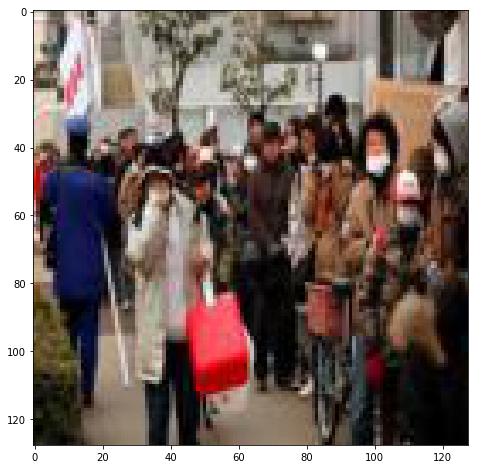

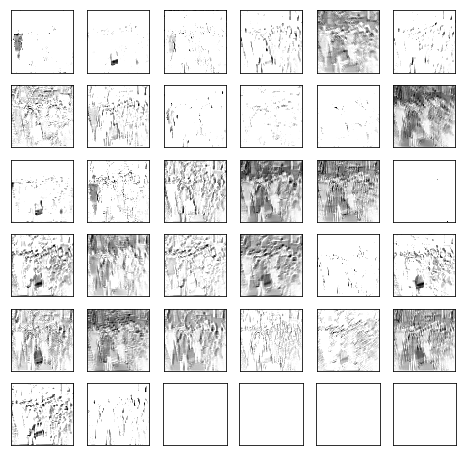

In [21]:
plot_image(scm.imread(RSZ_TEST_IMG_DIR + testing_data[0]))
plot_conv_layer(layer=layer_conv1, image=scm.imread(RSZ_TEST_IMG_DIR + testing_data[0]))

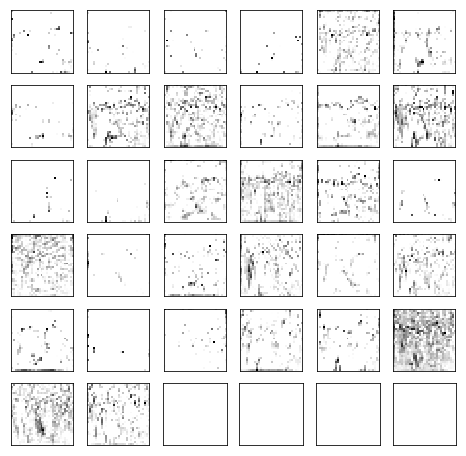

In [22]:
plot_conv_layer(layer=layer_conv2, image=scm.imread(RSZ_TEST_IMG_DIR + testing_data[0]))

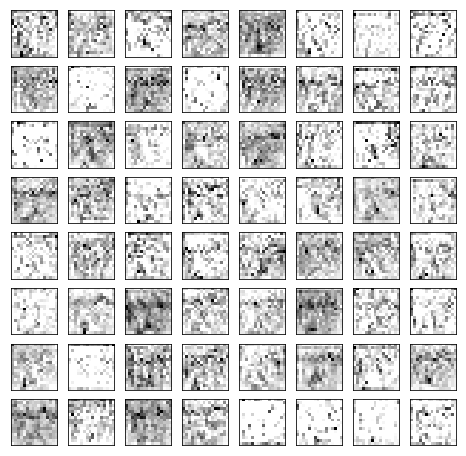

In [23]:
plot_conv_layer(layer=layer_conv3, image=scm.imread(RSZ_TEST_IMG_DIR + testing_data[0]))

In [24]:
def plot_conv_weights(weights, input_channel=0):
    
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    
    # Get number of filters
    num_filters = w.shape[3]

    # Number of grids for x and y axes.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        
        if i < num_filters:
            
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove graph lines
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

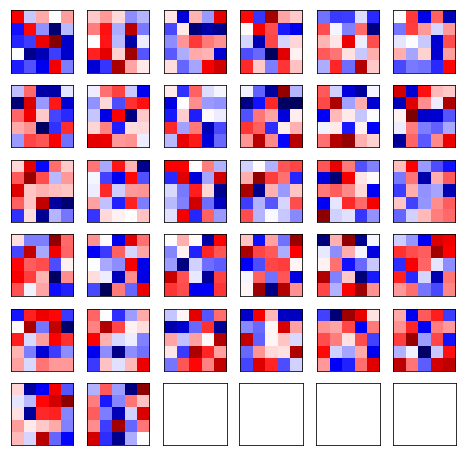

In [25]:
plot_conv_weights(weights=weights_conv1)